In [1]:
import pandas as pd

%matplotlib inline

In [2]:
df = pd.read_csv("data/un-general-debates-blueprint.csv")
df.sample(2)

,session,year,country,country_name,speaker,position,text
7065,68,2013,PNG,Papua New Guinea,Leo Dion,Deputy Prime Minister,I am honoured \nto deliver this statement on b...
6813,67,2012,ISL,Iceland,Össur Skarphéðinsson,Minister for Foreign Affairs,﻿It is a pleasure to\nbe able to address the G...


**Viewing columns**

In [3]:
cols = " | ".join(list(df.columns))
print("columns:", cols)

columns: session | year | country | country_name | speaker | position | text


**Viewing number of rows and cols**

In [4]:
df.shape

(7507, 7)

### Getting an overview of the data with pandas

1. calculate summary statistics
2. check for missing values
3. plot distributions of interesting attributes
4. compare distributions across categorires
5. visualize developments over time

In [5]:
df.columns

Index(['session', 'year', 'country', 'country_name', 'speaker', 'position',
       'text'],
      dtype='object')

In [6]:
df.dtypes

session          int64
year             int64
country         object
country_name    object
speaker         object
position        object
text            object
dtype: object

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7507 entries, 0 to 7506
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   session       7507 non-null   int64 
 1   year          7507 non-null   int64 
 2   country       7507 non-null   object
 3   country_name  7507 non-null   object
 4   speaker       7480 non-null   object
 5   position      4502 non-null   object
 6   text          7507 non-null   object
dtypes: int64(2), object(5)
memory usage: 410.7+ KB


**Calculating summary statistics for columns**

Tip: Transpose the columns `df.describe().T` for better visualization.

In [8]:
df["length"] = df["text"].str.len()
df.describe().T

,count,mean,std,min,25%,50%,75%,max
session,7507.0,49.610763,12.892155,25.0,39.0,51.0,61.0,70.0
year,7507.0,1994.610763,12.892155,1970.0,1984.0,1996.0,2006.0,2015.0
length,7507.0,17967.281604,7860.038463,2362.0,12077.0,16424.0,22479.5,72041.0


**Summary for non-numerical columns**

A summary for non-numerical columns can be produced by specifying `include='O'` (alias for `np.object`).

In [9]:
df[["country", "speaker"]].describe(include="O").T

,count,unique,top,freq
country,7507,199,IRN,46
speaker,7480,5428,Seyoum Mesfin,12


**Checking for missing data**

In [10]:
# isna() is just an alias to isnull(), but shorter.
df.isna().sum()

session            0
year               0
country            0
country_name       0
speaker           27
position        3005
text               0
length             0
dtype: int64

In [11]:
df["speaker"].fillna("uknown", inplace=True)

In [12]:
# Ambiguous/different spellings for a given speaker name.
df[df["speaker"].str.contains("Bush")]["speaker"].value_counts()

George W. Bush        4
Mr. George W. Bush    2
Mr. George W Bush     1
George Bush           1
Bush                  1
Name: speaker, dtype: int64

**Plotting Value Distributions**

<AxesSubplot:>

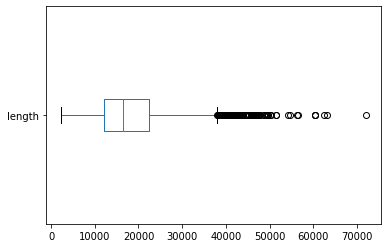

In [13]:
df["length"].plot(kind="box", vert=False)

<AxesSubplot:ylabel='Frequency'>

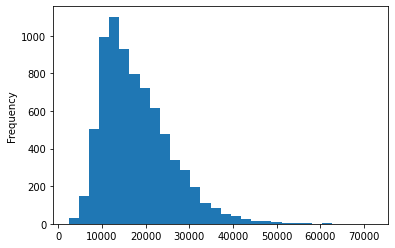

In [14]:
df["length"].plot(kind="hist", bins=30)

**Comparing Value Distributions across categories**

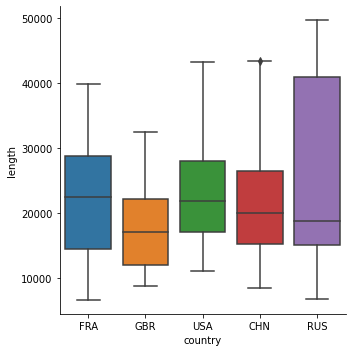

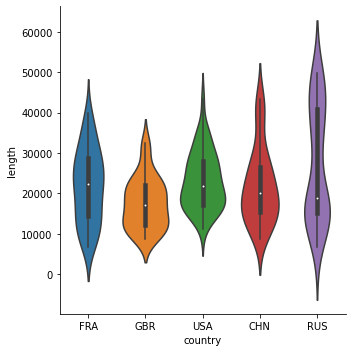

In [15]:
import seaborn as sns

where = df["country"].isin(["USA", "FRA", "GBR", "CHN", "RUS"])
sns.catplot(data=df[where], x="country", y="length", kind="box")
sns.catplot(data=df[where], x="country", y="length", kind="violin")

**Visualizing developments over time**

<AxesSubplot:title={'center':'Number of Countries'}, xlabel='year'>

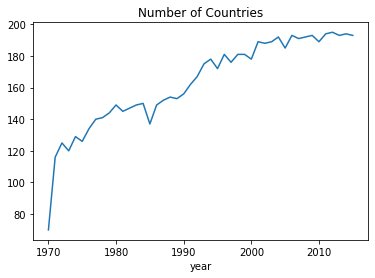

In [16]:
df.groupby("year").size().plot(title="Number of Countries")

<AxesSubplot:title={'center':'Avg. Speech Length'}, xlabel='year'>

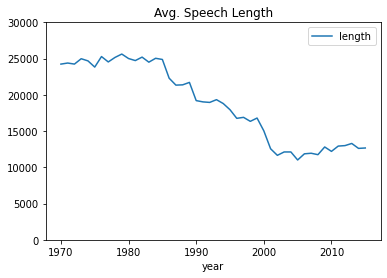

In [17]:
df.groupby("year").agg({"length": "mean"}).plot(
    title="Avg. Speech Length", ylim=(0, 30000)
)

## Building a Simple Text Preprocessing Pipeline

**Performing Tokenization with Regular Expressions**

In [18]:
import regex as re


# Using [A-Za-z] will miss accented characters.
# Much better is the POSIX character class \p{L} which selects all Unicode letters.
def tokenize(text):
    return re.findall(r"[\w-]*\p{L}[\w-]*", text)

In [19]:
text = "Let's defeat SARS-CoV-2 together in 2020!"
tokens = tokenize(text)
print("|".join(tokens))

Let|s|defeat|SARS-CoV-2|together|in


**Treating Stop Words**

For fast lookup, convert list to set. Sets are hash-based structure like dictionaries with nearly constant lookup time.

In [20]:
import nltk

stopwords = set(nltk.corpus.stopwords.words("english"))

print("would" in stopwords, "wouldn't" in stopwords)

include_stopwords = {"dear", "regards", "must", "would", "also"}
exclude_stopwords = {"against"}

stopwords |= include_stopwords
stopwords -= exclude_stopwords

False True


In [21]:
def remove_stop(tokens):
    # Note the lower, since the stopwords list is in lowercase,
    # Hence `I` will not match unless it is lowercased.
    return [t for t in tokens if t.lower() not in stopwords]

**Processing a Pipeline with One Line of Code**

In [22]:
pipeline = [str.lower, tokenize, remove_stop]


def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

In [23]:
df["tokens"] = df["text"].apply(prepare, pipeline=pipeline)

In [24]:
df["num_tokens"] = df["tokens"].map(len)

### Blueprints for Word Frequency Analysis

In [25]:
from collections import Counter

tokens = tokenize("She likes my cats and my cats like my sofa.")

counter = Counter(tokens)
counter

Counter({'She': 1,
         'likes': 1,
         'my': 3,
         'cats': 2,
         'and': 1,
         'like': 1,
         'sofa': 1})

In [26]:
more_tokens = tokenize("She likes dogs and cats")
counter.update(more_tokens)

counter

Counter({'She': 2,
         'likes': 2,
         'my': 3,
         'cats': 3,
         'and': 2,
         'like': 1,
         'sofa': 1,
         'dogs': 1})

In [27]:
# Finding the most frequent words within a corpus.
counter = Counter()

df["tokens"].map(counter.update)

counter.most_common(5)

[('nations', 124508),
 ('united', 120763),
 ('international', 117223),
 ('world', 89421),
 ('countries', 85734)]

In [28]:
def count_words(df, column="tokens", preprocess=None, min_freq=2):
    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data.
    counter = Counter()
    df[column].map(update)

    # transform counter into a DataFrame
    freq_df = pd.DataFrame.from_dict(counter, orient="index", columns=["freq"])
    freq_df = freq_df.query("freq >= @min_freq")
    freq_df.index.name = "token"

    return freq_df.sort_values("freq", ascending=False)

In [29]:
freq_df = count_words(df)
freq_df.head(5)

,freq
token,
nations,124508
united,120763
international,117223
world,89421
countries,85734


### Blueprint: Creating a Frequency Diagram

[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token'), Text(0.5, 1.0, 'Top Words')]

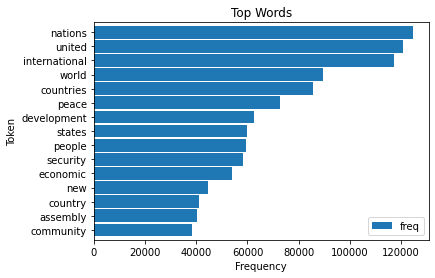

In [30]:
ax = freq_df.head(15).plot(kind="barh", width=0.9)
ax.invert_yaxis()
ax.set(xlabel="Frequency", ylabel="Token", title="Top Words")

### Blueprint: Creating Word Clouds

(-0.5, 399.5, 199.5, -0.5)

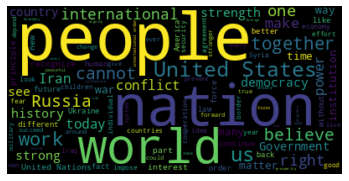

In [31]:
# !pip install wordcloud

import matplotlib.pyplot as plt
from wordcloud import WordCloud

%matplotlib inline

text = df.query("year == 2015 and country == 'USA'")["text"].values[0]

wc = WordCloud(max_words=100, stopwords=stopwords)
wc.generate(text)

plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

A more performant way of generating wordcloud for a large set of documents is to create a frequency counter first.

In [32]:
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):
    wc = WordCloud(
        width=800,
        height=400,
        background_color="black",
        colormap="Paired",
        max_font_size=150,
        max_words=max_words,
    )

    # Convert DataFrame to dict.
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # Filter stop words in frequency counter.
    if stopwords is not None:
        counter = {
            token: freq for (token, freq) in counter.items() if token not in stopwords
        }

    wc.generate_from_frequencies(counter)

    plt.title(title)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

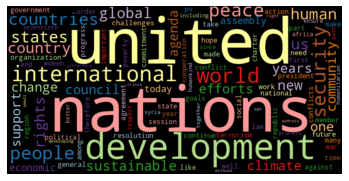

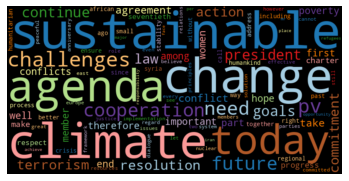

In [33]:
freq_2015_df = count_words(df[df["year"] == 2015])

plt.figure()

wordcloud(freq_2015_df["freq"], max_words=100)

# Exclude the top 50 words.
wordcloud(freq_2015_df["freq"], max_words=100, stopwords=freq_df.head(50).index)

### Blueprint: Ranking with TF-IDF

The function to compute IDF for all terms in the corpus is similar to `count_words`, except that each token is counted only once per document `counter.update(set(tokens))`, and the IDF values are computed after counting.

In [34]:
import numpy as np


def compute_idf(df, column="tokens", preprocess=None, min_df=2):
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(set(tokens))

    # Count tokens.
    counter = Counter()
    df[column].map(update)

    # Create DataFrame and compute IDF.
    idf_df = pd.DataFrame.from_dict(counter, orient="index", columns=["df"])
    idf_df = idf_df.query("df >= @min_df")

    # Avoid error "A value is trying to be set on a copy of a slice from a DataFrame."
    # by creating a copy.
    idf_df = idf_df.loc[:, ["df"]]
    idf_df["idf"] = np.log(len(df) / idf_df["df"]) + 0.1
    idf_df.index.name = "token"

    return idf_df

In [35]:
idf_df = compute_idf(df)

freq_df["tfidf"] = freq_df["freq"] * idf_df["idf"]

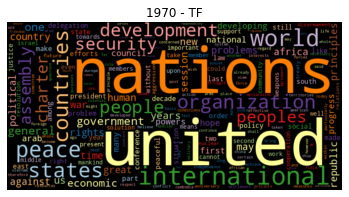

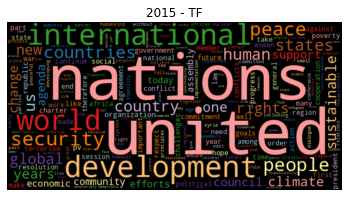

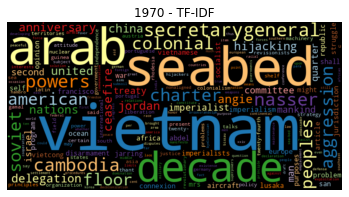

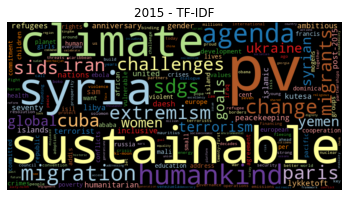

In [36]:
freq_1970 = count_words(df[df["year"] == 1970])
freq_2015 = count_words(df[df["year"] == 2015])

freq_1970["tfidf"] = freq_1970["freq"] * idf_df["idf"]
freq_2015["tfidf"] = freq_2015["freq"] * idf_df["idf"]

wordcloud(
    freq_1970["freq"], title="1970 - TF", stopwords=["twenty-fifth", "twenty-five"]
)
wordcloud(freq_2015["freq"], title="2015 - TF", stopwords=["seventieth"])

wordcloud(
    freq_1970["tfidf"],
    title="1970 - TF-IDF",
    stopwords=["twenty-fifth", "twenty-five", "twenty", "fifth"],
)
wordcloud(
    freq_2015["tfidf"],
    title="2015 - TF-IDF",
    stopwords=["seventieth"],
)

### Blueprint: Finding a Keyword-in-Context

In [37]:
# !pip install textacy
import random

from textacy.extract.kwic import keyword_in_context


def kwic(doc_series, keyword, window=35, print_samples=5):
    def add_kwic(text):
        kwic_list.extend(
            keyword_in_context(text, keyword, ignore_case=True, window_width=window)
        )

    kwic_list = []
    doc_series.map(add_kwic)

    if print_samples is None or print_samples == 0:
        return kwic_list
    else:
        k = min(print_samples, len(kwic_list))
        print(f"{k} random samples out of {len(kwic_list)} contexts for '{keyword}':")
        for sample in random.sample(list(kwic_list), k):
            print(
                re.sub(r"[\n\t]", " ", sample[0])
                + " "
                + sample[1]
                + " "
                + re.sub(r"[\n\t]", " ", sample[2]),
            )

In [38]:
kwic(df[df["year"] == 2015]["text"], "sdgs", print_samples=5)

5 random samples out of 73 contexts for 'sdgs':
eholder for and beneficiary of the  SDGs . The development of human capital 
ction. That can happen only if the  SDGs  are matched with the necessary res
 make progress on those Goals. The  SDGs  must not simply be a reference poi
its Sustainable Development Goals ( SDGs ) (resolution 70/1), which can be c
also hinder the realization of the  SDGs . We therefore call for the early l


### Blueprint: Analyzing N-Grams

In [39]:
def ngrams(tokens, n=2, sep=" "):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])]


text = "the visible manifestation of the global climate change"
tokens = tokenize(text)
print("|".join(ngrams(tokens)))

the visible|visible manifestation|manifestation of|of the|the global|global climate|climate change


The recommended way to build bigrams without stopwords is to generate bigrams of all tokens, and remove those that contains stopwords. Doing it the opposite way (remove stopwords, generate bigrams) will lead to bigrams that does not exists in the original text.

In [40]:
def ngrams(tokens, n=2, sep=" ", stopwords=set()):
    return [
        sep.join(ngram)
        for ngram in zip(*[tokens[i:] for i in range(n)])
        if len([t for t in ngram if t in stopwords]) == 0
    ]


print("Bigrams:", "|".join(ngrams(tokens, 2, stopwords=stopwords)))
print("Trigrams:", "|".join(ngrams(tokens, 3, stopwords=stopwords)))

Bigrams: visible manifestation|global climate|climate change
Trigrams: global climate change


In [41]:
df["bigrams"] = (
    df["text"]
    .apply(prepare, pipeline=[str.lower, tokenize])
    .apply(ngrams, n=2, stopwords=stopwords)
)

In [42]:
count_words(df, "bigrams").head(5)

,freq
token,
united nations,103236
international community,27786
general assembly,27096
security council,20961
human rights,19856


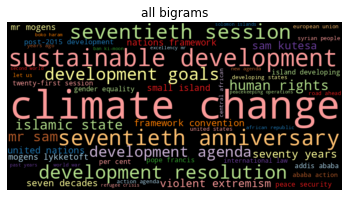

In [43]:
# Concatenate existing IDF DataFrame with bigram IDFs.
idf_df = pd.concat([idf_df, compute_idf(df, "bigrams", min_df=10)])

freq_df = count_words(df[df["year"] == 2015], "bigrams")
freq_df["tfidf"] = freq_df["freq"] * idf_df["idf"]
wordcloud(freq_df["tfidf"], title="all bigrams", max_words=50)

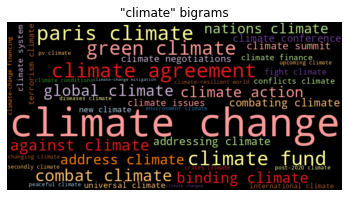

In [44]:
where = freq_df.index.str.contains("climate")
wordcloud(freq_df[where]["freq"], title='"climate" bigrams', max_words=50)

### Blueprint: Comparing Frequencies Across time Intervals and Categories

**Creating Frequency Timelines**

In [45]:
def count_keywords(tokens, keywords):
    tokens = [t for t in tokens if t in keywords]
    counter = Counter(tokens)
    return [counter.get(k, 0) for k in keywords]

In [46]:
keywords = ["nuclear", "terrorism", "climate", "freedom"]
tokens = ["nuclear", "climate", "climate", "freedom", "climate", "freedom"]

print(count_keywords(tokens, keywords))

[1, 0, 3, 2]


In [47]:
def count_keywords_by(df, by, keywords, column="tokens"):
    freq_matrix = df[column].apply(count_keywords, keywords=keywords)
    freq_df = pd.DataFrame.from_records(freq_matrix, columns=keywords)
    freq_df[by] = df[by]  # Copy the grouping column(s)

    return freq_df.groupby(by=by).sum().sort_values(by)

In [48]:
freq_df = count_keywords_by(df, "year", keywords=keywords)
freq_df

,nuclear,terrorism,climate,freedom
year,,,,
1970,192,7,18,128
1971,275,9,35,205
1972,393,379,74,280
1973,347,124,79,266
1974,478,24,71,316
1975,578,20,53,232
1976,451,146,57,347
1977,675,75,58,321
1978,550,82,52,309


<AxesSubplot:xlabel='year'>

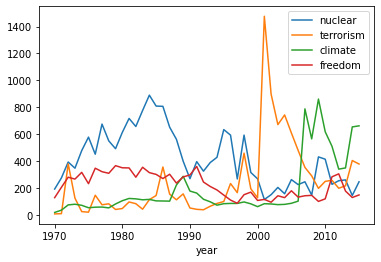

In [49]:
freq_df.plot(kind="line")

**Creating frequency heatmaps**

In [50]:
keywords = [
    "terrorism",
    "terrorist",
    "nuclear",
    "war",
    "oil",
    "syria",
    "syrian",
    "refugees",
    "migration",
    "peacekeeping",
    "humanitarian",
    "climate",
    "change",
    "sustainable",
    "sdgs",
]

freq_df = count_keywords_by(df, by="year", keywords=keywords)

# Compute relative frequencies based on total number of tokens per year.
freq_df = freq_df.div(df.groupby("year")["num_tokens"].sum(), axis=0)

# Apply square root as sublinear filter for better contrast.
freq_df = freq_df.apply(np.sqrt)

<AxesSubplot:xlabel='year'>

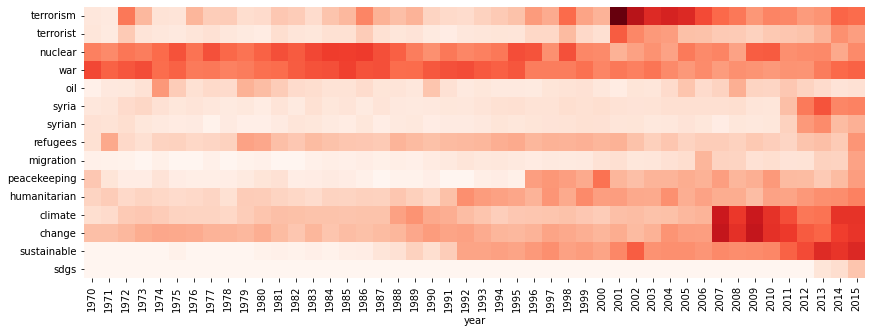

In [51]:
plt.figure(figsize=(14, 5))
sns.heatmap(data=freq_df.T, xticklabels=True, yticklabels=True, cbar=False, cmap="Reds")